In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
import ReactiveMP: rule, marginalrule, score

function ReactiveMP.rule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean}}, 
        ::Marginalisation, 
        ::Nothing, 
        marginals::Tuple{Marginal,Marginal}, 
        ::Nothing)
    return NormalMeanVariance(mean(marginals[2]), mean(marginals[1]))
end

function ReactiveMP.rule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:value}}, 
        ::Marginalisation, 
        ::Nothing, 
        marginals::Tuple{Marginal, Marginal}, 
        ::Nothing)
    return NormalMeanVariance(mean(marginals[1]), mean(marginals[2]))
end

function ReactiveMP.marginalrule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean_variance_value}}, 
        messages::Tuple{Message{Float64},Message{Float64},Message{NormalMeanVariance{Float64}}}, 
        ::Nothing,
        ::Nothing)
    q_out = Message(NormalMeanVariance(getdata(messages[1]), getdata(messages[2]))) * messages[3]
    return (getdata(messages[1]), getdata(messages[2]), getdata(q_out))
end

function ReactiveMP.marginalrule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean_variance_value}}, 
        messages::Tuple{Message{NormalMeanVariance{Float64}},Message{Float64},Message{Float64}}, 
        ::Nothing,
        ::Nothing)
    q_mean = Message(NormalMeanVariance(getdata(messages[3]), getdata(messages[2]))) * messages[1]
    return (getdata(q_mean), getdata(messages[2]), getdata(messages[3]))
end

In [3]:
import LinearAlgebra: det

logmean(marginal::Marginal{Float64}) = log(getdata(marginal))
inversemean(marginal::Marginal{Float64}) = 1.0 / getdata(marginal)

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal{Tuple{Float64,Float64,NormalMeanVariance{Float64}}}})
    factorised = map(as_marginal, getdata(marginals[1]))
    return score(AverageEnergy(), NormalMeanVariance{Float64}, factorised)
end

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal{Tuple{NormalMeanVariance{Float64}, Float64,Float64}}})
    factorised = map(as_marginal, getdata(marginals[1]))
    return score(AverageEnergy(), NormalMeanVariance{Float64}, factorised)
end

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal,Marginal,Marginal})
    
    m_mean, v_mean = mean(marginals[1]), var(marginals[1])
    m_out, v_out = mean(marginals[3]), var(marginals[3])

    0.5*log(2*pi) +
    0.5*logmean(marginals[2]) +
    0.5*inversemean(marginals[2])*(v_out + v_mean + (m_out - m_mean)^2)
end

function ReactiveMP.score(
        ::AverageEnergy,
        ::Type{GCV}, 
        marginals::Tuple{
            Marginal{MvNormalMeanCovariance{Float64}},
            Marginal{NormalMeanVariance{Float64}},
            Marginal{Float64},
            Marginal{Float64}
        })
    # m_out_x, cov_out_x = reverse(mean(marginals[1])), mirrormatrix(cov(marginals[1]))
    m_x_out, cov_x_out = mean(marginals[1]), cov(marginals[1])
    m_z, var_z = mean(marginals[2]), var(marginals[2])
    m_κ, var_κ = mean(marginals[3]), var(marginals[3])
    m_ω, var_ω = mean(marginals[4]), var(marginals[4])

    ksi = (m_κ^2)*var_z + (m_z^2)*var_κ + var_κ*var_z
    psi = (m_x_out[1]-m_x_out[2])^2 + cov_x_out[2,2]+cov_x_out[1,1]-cov_x_out[2,1]-cov_x_out[1,2]
    A = exp(-m_ω + var_ω/2)
    B = exp(-m_κ*m_z + ksi/2)

    return 0.5 * log(2pi) + 0.5 * (m_z*m_κ+m_ω) + 0.5 * (psi*A*B)
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{ <: Tuple })
    return mapreduce((d) -> score(DifferentialEntropy(), as_marginal(d)), +, getdata(marginal), init = 0.0)
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{Float64})
    return 0.0
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{NormalMeanVariance{Float64}})
    return 0.5 * log(var(marginal)) + 0.5 * log(2pi) + 0.5
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{MvNormalMeanCovariance{Float64}})
   dims = length(mean(marginal)) 
   return 0.5*log(det(cov(marginal))) + (dims / 2.0)*log(2pi) + (dims / 2.0) 
end

In [15]:
function hgf_timeslice(model, zt_prev, xt_prev, real_k, real_w, z_variance, y_variance)
    
    zvar = add!(model, constvar(:zvar, z_variance))
    zt   = add!(model, randomvar(:zt))
    
    z_transition = add!(model, make_node(NormalMeanVariance{Float64}, zt_prev, zvar, zt, factorisation = ((1,),(2,),(3,))))
    
    xt = add!(model, randomvar(:xt))
    kt = add!(model, constvar(:kt, real_k))
    ωt = add!(model, constvar(:wt, real_w))
    
    gcv = add!(model, make_node(GCV, xt_prev, zt, kt, ωt, xt))
    
    y_var = add!(model, constvar(:y_var, y_variance))
    y     = add!(model, datavar(:y, Float64))
    
    obs = add!(model, make_node(NormalMeanVariance{Float64}, xt, y_var, y))
    
    return (zt, xt, y, gcv)
end

function hgf(n, iters, data, real_k, real_w, z_variance, y_variance)
    model = Model(DefaultMessageGate())
    
    zs = Vector{RandomVariable}(undef, n)
    xs = Vector{RandomVariable}(undef, n)
    ys = Vector{DataVariable}(undef, n)
    
    zt_1_mean = add!(model, datavar(:zt_1_mean, Float64))
    zt_1_var  = add!(model, datavar(:zt_1_var, Float64))
    zt_1      = add!(model, randomvar(:zt_1))
    
    xt_1_mean = add!(model, datavar(:xt_1_mean, Float64))
    xt_1_var  = add!(model, datavar(:xt_1_var, Float64))
    xt_1      = add!(model, randomvar(:xt_1))
    
    zt_1_prior = add!(model, make_node(NormalMeanVariance{Float64}, zt_1_mean, zt_1_var, zt_1))
    xt_1_prior = add!(model, make_node(NormalMeanVariance{Float64}, xt_1_mean, xt_1_var, xt_1))    
    
    prev_zt_n = zt_1
    prev_xt_n = xt_1
    
    mz = Vector{NormalMeanVariance}(undef, n)
    mx = Vector{NormalMeanVariance}(undef, n)
    gcv = Vector{FactorNode}(undef, n)
    
    mz_subs = Vector{Teardown}(undef, n)
    mx_subs = Vector{Teardown}(undef, n)
    
    ms_scheduler = PendingScheduler()

    for i in 1:n
        zt_n, xt_n, y_n, gcv_n = hgf_timeslice(model, prev_zt_n, prev_xt_n, real_k, real_w, z_variance, y_variance)
        
        zs[i] = zt_n
        xs[i] = xt_n
        ys[i] = y_n
        gcv[i] = gcv_n
        
        mz_subs[i] = subscribe!(getmarginal(zt_n) |> schedule_on(ms_scheduler), (t) -> mz[i] = getdata(t))
        mx_subs[i] = subscribe!(getmarginal(xt_n) |> schedule_on(ms_scheduler), (t) -> mx[i] = getdata(t))
    
        prev_zt_n = zt_n
        prev_xt_n = xt_n
    end
    
    activate!(model)
    
    foreach(gcv) do gcv_node
        setmarginal!(gcv_node, :x_y, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
        setmarginal!(gcv_node, :z, NormalMeanVariance(0.0, 5.0)) 
    end
    
    # Initial messages
    prior_zt = NormalMeanVariance(0.0, 100.0)
    prior_xt = NormalMeanVariance(0.0, 100.0)
    
    fe = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    for _ in 1:iters
        update!(zt_1_mean, mean(prior_zt))
        update!(zt_1_var, var(prior_zt))
        update!(xt_1_mean, mean(prior_xt))
        update!(xt_1_var, var(prior_xt))

        for i in 1:n
            update!(ys[i], data[i])
        end
        
        release!(fe_scheduler)
    end
    
    release!(ms_scheduler)
 
    foreach(unsubscribe!, mz_subs)
    foreach(unsubscribe!, mx_subs)
    unsubscribe!(fe_sub)
    
    return mz, mx, fe
end

hgf (generic function with 1 method)

In [45]:
n = 1000
iters = 20

Random.seed!(223)

real_k = 1.0
real_w = 2.0

z_prev     = 0.0
z_variance = 0.1

z = Vector{Float64}(undef, n)
for i in 1:n
    z[i] = rand(Normal(z_prev, sqrt(z_variance)))
    z_prev = z[i]
end

# z = map(d -> 2.0 * sin(0.005 * d), 1:n)

v = map(d -> exp(real_k * d + real_w), z)

x_prev = 0.0

x = Vector{Float64}(undef, n)

for i in 1:n
    x[i] = rand(Normal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Float64}(undef, n)
y_variance = 1.0

for i in 1:n
    y[i] = rand(Normal(x[i], sqrt(y_variance)))
end

In [46]:
@time mz, mx, fe = hgf(n, iters, y, real_k, real_w, z_variance, y_variance);

  1.433785 seconds (7.27 M allocations: 386.369 MiB, 29.00% gc time)


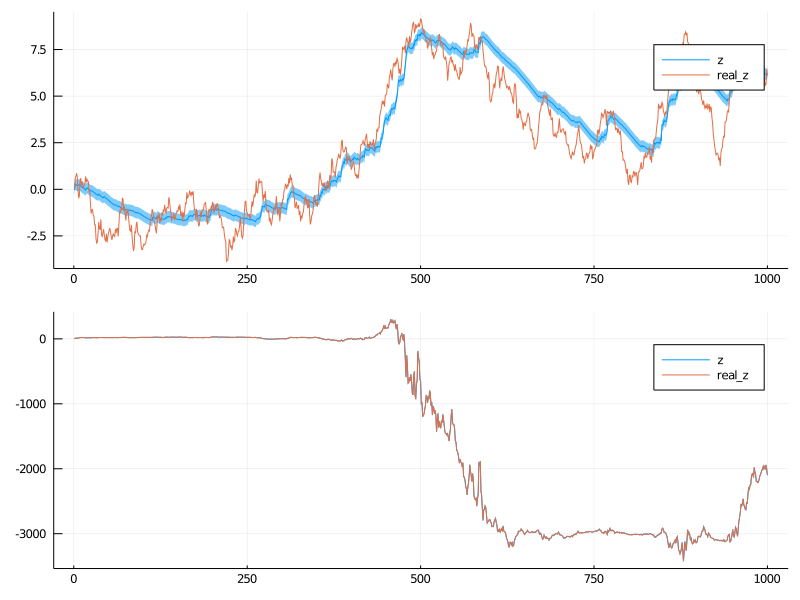

In [50]:
plot(mean.(mz), ribbon = std.(mz), label = :z)
p1 = plot!(z, label = :real_z)

plot(mean.(mx), ribbon = std.(mx), label = :z)
p2 = plot!(x, label = :real_z)

plot(p1, p2, layout = (2, 1), size = (800, 600))

# fevalues = reshape(fe, (iters, n))
# p3 = plot(sum(fevalues, dims = 2) / n)

# plot(p1, p2, p3, size = (1000, 600))

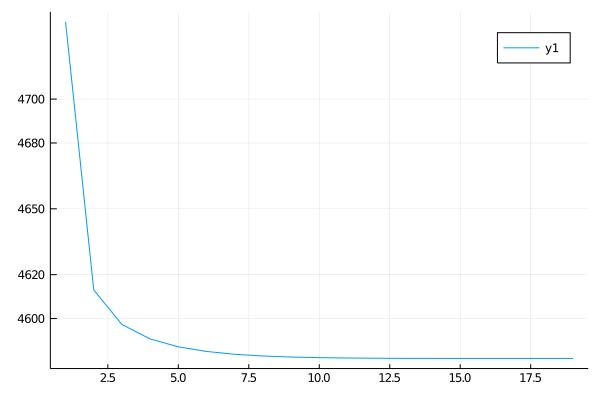

In [51]:
plot(fe[2:end])

In [52]:
@btime hgf($n, $iters, $y, $real_k, $real_w, $z_variance, $y_variance);

  1.304 s (7270939 allocations: 386.37 MiB)
